Proposed model achieves 97% test accuracy (no seed was set, so there will be some randomeness when recreating this code).

Simple neural network model for MNIST classification. 
Number of hidden layers and neurons were chosen using randomized search.
<br>Learning rate was exponentially increased using callbacks and then plotted, so that the optimal value could be chosen.
<br>Final model consisted of 1 hidden layer with 250 neurons and learning rate of 0.65. It was trained for 28 epochs (early stopping)
reaching 97% test accuracy. 

In [1]:
import tensorflow as tf

In [2]:
# download data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() 

In [6]:
x_train.shape # 60000 obs, 28x28
# Pixel values range from 0 to 255.
# y - 10 classes

(60000, 28, 28)

In [3]:
# create validation set and scale the data
x_valid, x_train = x_train[:5000] /255., x_train[5000:] /255.
y_valid, y_train = y_train[:5000], y_train[5000:]
x_test = x_test / 255.

In [18]:
# info about the shape of data
def shape_info(sets=["x_train","x_valid","x_test","y_train","y_valid","y_test"]):
    for set in sets:
        print(f"{set}'s shape: {eval(set).shape}")

shape_info()

x_train's shape: (55000, 28, 28)
x_valid's shape: (5000, 28, 28)
x_test's shape: (10000, 28, 28)
y_train's shape: (55000,)
y_valid's shape: (5000,)
y_test's shape: (10000,)


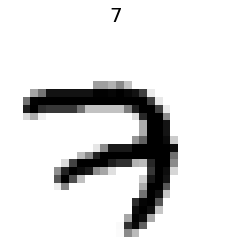

In [14]:
import matplotlib.pyplot as plt

def plot_image(idx, fsize=12):
    plt.imshow(x_train[idx], cmap = 'binary')
    plt.title(y_train[idx], fontsize=fsize)
    plt.axis('off')

plot_image(0, fsize=20)
plt.show()

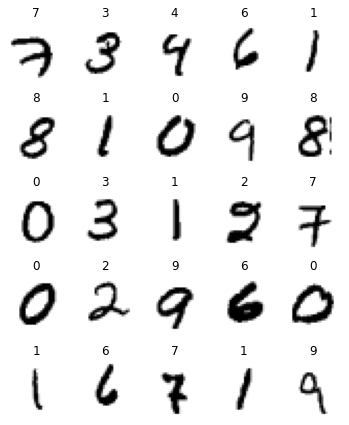

In [29]:
def plot_many_images(n_rows, n_cols):
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.5))
    for row in range(n_rows):
        for col in range(n_cols):
            idx = row * n_cols + col
            # indexes from 0 to n_cols * n_rows -1
            plt.subplot(n_rows, n_cols, idx + 1)
            # position of subplot
            plot_image(idx=idx)

plot_many_images(5,5)
plt.show()

In [4]:
# neural network
from keras.layers import Flatten, Dense

def model_mnist(n_hidden, n_neurons, l_rate=0.035):
    model = tf.keras.models.Sequential()
    model.add(Flatten(input_shape=[28,28]))
    for i in range(n_hidden):
        model.add(Dense(n_neurons, "relu"))
    model.add(Dense(10, "softmax"))
    model.compile(loss="sparse_categorical_crossentropy",#cause we're predicting more than 2 classes
              optimizer=tf.keras.optimizers.SGD(learning_rate=l_rate),
              metrics=["accuracy"])
    return model

In [5]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(model_mnist)

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(50, 300, 50).tolist()
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, cv=3, verbose=2)
rnd_search_cv.fit(x_train, y_train, epochs=100,
                  validation_data=(x_valid, y_valid),
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

C:\Users\Natka\AppData\Local\Temp\ipykernel_4992\2907591789.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(model_mnist)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
1146/1146 [==============================] - 1s 1ms/step - loss: 0.4917 - accuracy: 0.8557 - val_loss: 0.2270 - val_accuracy: 0.9358
Epoch 2/100
1146/1146 [==============================] - 1s 988us/step - loss: 0.2090 - accuracy: 0.9367 - val_loss: 0.1794 - val_accuracy: 0.9476
Epoch 3/100
1146/1146 [==============================] - 1s 1ms/step - loss: 0.1557 - accuracy: 0.9533 - val_loss: 0.1362 - val_accuracy: 0.9614
Epoch 4/100
1146/1146 [==============================] - 1s 1ms/step - loss: 0.1215 - accuracy: 0.9635 - val_loss: 0.1396 - val_accuracy: 0.9592
Epoch 5/100
1146/1146 [==============================] - 1s 993us/step - loss: 0.1004 - accuracy: 0.9698 - val_loss: 0.1128 - val_accuracy: 0.9668
Epoch 6/100
1146/1146 [==============================] - 1s 1ms/step - loss: 0.0837 - accuracy: 0.9741 - val_loss: 0.1067 - val_accuracy: 0.9672
Epoch 7/100
1146/1146 [==============================] - 1s 1ms/s

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000021150DA3460>,
                   param_distributions={'n_hidden': [1, 2, 3],
                                        'n_neurons': [50, 100, 150, 200, 250]},
                   verbose=2)

In [6]:
rnd_search_cv.best_params_
# 250 neurons, 1 hidden best

{'n_neurons': 250, 'n_hidden': 1}

In [7]:
rnd_search_cv.best_score_

-0.09232253829638164

In [8]:
tf.keras.backend.clear_session()

In [9]:
# let's search for the optimal learning rate 
# callback will update the learning rate and record losses for each lr
K = tf.keras.backend

#callback class:
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        # learning rate will be updated by the factor:
        self.factor = factor
        # we want to store rates and losses:
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        # learning rate will be updated for every batch
        # rates and losses:
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        # update:
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor) 

In [10]:
model = model_mnist(1, 250, l_rate=0.003) # initial lr very small
expon_lr = ExponentialLearningRate(factor=1.005) # we're updating lr by 0.5%

In [11]:
# now we'll be ti=uning the learning rate
# let's train model for 1 epoch and use callbacks
history = model.fit(x_train, y_train, epochs=1,
                    validation_data=(x_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 3s 2ms/step - loss: 1.4065 - accuracy: 0.6285 - val_loss: 3.0740 - val_accuracy: 0.1002


In [12]:
import numpy as np
idx = np.argmin(expon_lr.losses)
expon_lr.rates[idx]

1.337247

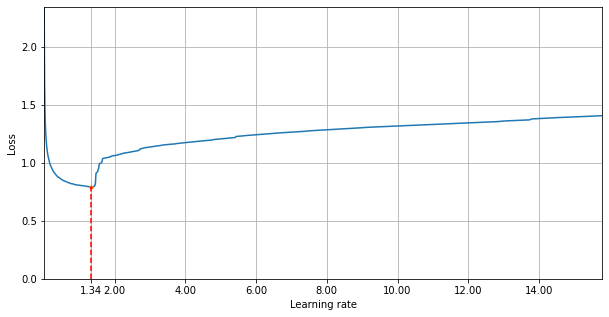

In [16]:
# plot learning rate
plt.figure(figsize=(10,5))
plt.plot(expon_lr.rates, expon_lr.losses)
plt.plot(expon_lr.rates[idx], expon_lr.losses[idx], marker='.' ,markerfacecolor='red')
plt.plot([expon_lr.rates[idx],expon_lr.rates[idx]],[0, expon_lr.losses[idx]], 'r--')
plt.xticks(list(plt.xticks()[0])+[expon_lr.rates[idx]])
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.grid()

# loss starts to grow around lr = 1.34
# rule of thumb is to use half of that rate - 0.65

In [17]:
tf.keras.backend.clear_session()
model = model_mnist(1,250,0.65)

In [18]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)

history = model.fit(x_train, y_train, epochs=100,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2510 - accuracy: 0.9226 - val_loss: 0.1585 - val_accuracy: 0.9518
Epoch 2/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1095 - accuracy: 0.9667 - val_loss: 0.1187 - val_accuracy: 0.9682
Epoch 3/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0808 - accuracy: 0.9753 - val_loss: 0.1018 - val_accuracy: 0.9732
Epoch 4/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0629 - accuracy: 0.9805 - val_loss: 0.1050 - val_accuracy: 0.9714
Epoch 5/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0506 - accuracy: 0.9833 - val_loss: 0.1316 - val_accuracy: 0.9700
Epoch 6/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0436 - accuracy: 0.9865 - val_loss: 0.1040 - val_accuracy: 0.9754
Epoch 7/100
1719/1719 [==============================] - 3s 2ms/step - loss: 0.0376 - accuracy: 0.9882 - val_loss: 0.1097 - val_ac

In [24]:
best_model = model = tf.keras.models.load_model("my_mnist_model.h5")
print(f"Model's accuracy: {round(best_model.evaluate(x_test, y_test)[1],2)}")

313/313 [==============================] - 0s 1ms/step - loss: 0.1203 - accuracy: 0.9734
Model's accuracy: 0.97
